In [ ]:
!pip install librosa opencv-python scikit-learn matplotlib pandas tqdm
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

GPU Available: True
GPU Device Name: Tesla T4
Using device: cuda


In [ ]:
!mkdir -p /content/data/RAVDESS/audio
!mkdir -p /content/data/RAVDESS/video

# Download the audio speech data (all actors, ~208 MB)
!wget -O /content/data/RAVDESS/audio/Audio_Speech_Actors_01-24.zip https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

!unzip -q /content/data/RAVDESS/audio/Audio_Speech_Actors_01-24.zip -d /content/data/RAVDESS/audio/

# Download video files
# We'll use 8 actors (4 male, 4 female) for a balanced dataset
# Male actors: 01, 03, 05, 07 (odd numbers)
# Female actors: 02, 04, 06, 08 (even numbers)

for actor_id in ['01', '02', '03', '04', '05', '06', '07', '08']:
    print(f"Downloading video for Actor_{actor_id}...")
    !wget -O /content/data/RAVDESS/video/Video_Speech_Actor_{actor_id}.zip https://zenodo.org/record/1188976/files/Video_Speech_Actor_{actor_id}.zip
    !unzip -q /content/data/RAVDESS/video/Video_Speech_Actor_{actor_id}.zip -d /content/data/RAVDESS/video/
    # Remove the zip file to save space
    !rm /content/data/RAVDESS/video/Video_Speech_Actor_{actor_id}.zip


--2025-03-22 08:09:44--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2025-03-22 08:09:45--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘/content/data/RAVDESS/audio/Audio_Speech_Actors_01-24.zip’

/content/data/RAVDE 100%[===================>] 198.81M  12.5MB/s    in 17s     

2025-03-22 08:10:02 (11.5 MB/s) - ‘/content/data/RAVDESS/audio/Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]

--2025-03-22 08:10:11--  https://zenodo.org/record/1188976/files/Video_Speech_Actor_01.zip
R

In [ ]:
import os
import pandas as pd
import glob

def create_ravdess_dataframe():
    """
    Create a DataFrame with paths to audio and video files and their emotion labels.

    The RAVDESS filename format is:
    modality-vocal_channel-emotion-intensity-statement-repetition-actor.extension

    Emotions: 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry,
              06 = fearful, 07 = disgust, 08 = surprised
    """
    data = []

    # Get all audio files
    audio_files = glob.glob('/content/data/RAVDESS/audio/**/*.wav', recursive=True)

    for audio_path in audio_files:
        filename = os.path.basename(audio_path)
        parts = filename.split('-')

        if len(parts) >= 7:
            # Extract information from filename
            modality = parts[0]  # 03 = audio-only
            vocal_channel = parts[1]  # 01 = speech
            emotion_id = int(parts[2])
            intensity = parts[3]  # 01 = normal, 02 = strong
            statement = parts[4]
            repetition = parts[5]
            actor_id = parts[6].split('.')[0]

            # Map emotion ID to label
            emotion_map = {
                1: 'neutral',
                2: 'calm',
                3: 'happy',
                4: 'sad',
                5: 'angry',
                6: 'fearful',
                7: 'disgust',
                8: 'surprised'
            }
            emotion = emotion_map.get(emotion_id, 'unknown')

            # Video files have modality 01 (full-AV)
            video_filename = f"01-{vocal_channel}-{parts[2]}-{intensity}-{statement}-{repetition}-{actor_id}.mp4"
            video_path = None

            # Only look for video files for actors 01-08
            if int(actor_id) <= 8:
                potential_video_paths = glob.glob(f'/content/data/RAVDESS/video/**/{video_filename}', recursive=True)
                if potential_video_paths:
                    video_path = potential_video_paths[0]

            # Only include samples with both audio and video
            if video_path:
                data.append({
                    'audio_path': audio_path,
                    'video_path': video_path,
                    'emotion': emotion,
                    'emotion_id': emotion_id,
                    'intensity': 'normal' if intensity == '01' else 'strong',
                    'actor_id': actor_id,
                    'gender': 'male' if int(actor_id) % 2 == 1 else 'female'
                })

    df = pd.DataFrame(data)
    return df

df = create_ravdess_dataframe()

# Display info about dataset
print(f"Total samples with both audio and video: {len(df)}")
print(f"Emotion distribution:\n{df['emotion'].value_counts()}")
print(f"Gender distribution:\n{df['gender'].value_counts()}")
print(f"Intensity distribution:\n{df['intensity'].value_counts()}")

# Save the DataFrame
df.to_csv('/content/data/RAVDESS/ravdess_metadata.csv', index=False)

df.head()


Total samples with both audio and video: 480
Emotion distribution:
emotion
happy        64
angry        64
disgust      64
calm         64
fearful      64
surprised    64
sad          64
neutral      32
Name: count, dtype: int64
Gender distribution:
gender
male      240
female    240
Name: count, dtype: int64
Intensity distribution:
intensity
normal    256
strong    224
Name: count, dtype: int64


audio_path  \
0  /content/data/RAVDESS/audio/Actor_05/03-01-01-...   
1  /content/data/RAVDESS/audio/Actor_05/03-01-03-...   
2  /content/data/RAVDESS/audio/Actor_05/03-01-05-...   
3  /content/data/RAVDESS/audio/Actor_05/03-01-07-...   
4  /content/data/RAVDESS/audio/Actor_05/03-01-07-...   

                                          video_path  emotion  emotion_id  \
0  /content/data/RAVDESS/video/Actor_05/01-01-01-...  neutral           1   
1  /content/data/RAVDESS/video/Actor_05/01-01-03-...    happy           3   
2  /content/data/RAVDESS/video/Actor_05/01-01-05-...    angry           5   
3  /content/data/RAVDESS/video/Actor_05/01-01-07-...  disgust           7   
4  /content/data/RAVDESS/video/Actor_05/01-01-07-...  disgust           7   

  intensity actor_id gender  
0    normal       05   male  
1    normal       05   male  
2    normal       05   male  
3    strong       05   male  
4    strong       05   male

In [ ]:
df

audio_path  \
0    /content/data/RAVDESS/audio/Actor_05/03-01-01-...   
1    /content/data/RAVDESS/audio/Actor_05/03-01-03-...   
2    /content/data/RAVDESS/audio/Actor_05/03-01-05-...   
3    /content/data/RAVDESS/audio/Actor_05/03-01-07-...   
4    /content/data/RAVDESS/audio/Actor_05/03-01-07-...   
..                                                 ...   
475  /content/data/RAVDESS/audio/Actor_02/03-01-02-...   
476  /content/data/RAVDESS/audio/Actor_02/03-01-04-...   
477  /content/data/RAVDESS/audio/Actor_02/03-01-05-...   
478  /content/data/RAVDESS/audio/Actor_02/03-01-04-...   
479  /content/data/RAVDESS/audio/Actor_02/03-01-08-...   

                                            video_path    emotion  emotion_id  \
0    /content/data/RAVDESS/video/Actor_05/01-01-01-...    neutral           1   
1    /content/data/RAVDESS/video/Actor_05/01-01-03-...      happy           3   
2    /content/data/RAVDESS/video/Actor_05/01-01-05-...      angry           5   
3    /content/data/RAVDESS/video/Actor_05/01-01-07-...    disgust           7   
4    /content/data/RAVDESS/video/Actor_05/01-01-07-...    disgust           7   
..                                                 ...        ...         ...   
475  /content/data/RAVDESS/video/Actor_02/01-01-02-...       calm           2   
476  /content/data/RAVDESS/video/Actor_02/01-01-04-...        sad           4   
477  /content/data/RAVDESS/video/Actor_02/01-01-05-...      angry           5   
478  /content/data/RAVDESS/video/Actor_02/01-01-04-...        sad           4   
479  /content/data/RAVDESS/video/Actor_02/01-01-08-...  surprised           8   

    intensity actor_id  gender  
0      normal       05    male  
1      normal       05    male  
2      normal       05    male  
3      strong       05    male  
4      strong       05    male  
..        ...      ...     ...  
475    strong       02  female  
476    normal       02  female  
477    strong       02  female  
478    strong       02  female  
479    strong       02  female  

[480 rows x 7 columns]

In [ ]:
import numpy as np
import librosa
import cv2
from skimage.feature import hog
from skimage import color

def extract_audio_features(audio_path, max_length=3, sr=22050):
    """Extract audio features using librosa"""
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr, duration=max_length)

        # Pad if audio is shorter than max_length
        if len(y) < max_length * sr:
            y = np.pad(y, (0, max_length * sr - len(y)), 'constant')

        # Extract features
        # 1. MFCCs (Mel-frequency cepstral coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        mfccs_std = np.std(mfccs.T, axis=0)

        # 2. Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)
        chroma_std = np.std(chroma.T, axis=0)

        # 3. Mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_mean = np.mean(librosa.power_to_db(mel).T, axis=0)
        mel_std = np.std(librosa.power_to_db(mel).T, axis=0)

        # 4. Spectral contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        contrast_mean = np.mean(contrast.T, axis=0)
        contrast_std = np.std(contrast.T, axis=0)

        # 5. Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)

        # 6. Spectral rolloff
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        rolloff_mean = np.mean(rolloff)
        rolloff_std = np.std(rolloff)

        # Combine all features
        features = np.concatenate([
            mfccs_mean, mfccs_std,
            chroma_mean, chroma_std,
            mel_mean[:20], mel_std[:20],  # Limit mel features to reduce dimensionality
            contrast_mean, contrast_std,
            [zcr_mean, zcr_std, rolloff_mean, rolloff_std]
        ])

        return features
    except Exception as e:
        print(f"Error extracting audio features from {audio_path}: {e}")
        return None


def extract_video_features(video_path, num_frames=5, output_size=18900):
    """
    Extract video features using HOG (Histogram of Oriented Gradients)
    from selected frames and ensure consistent output size
    """
    try:
        cap = cv2.VideoCapture(video_path)

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate frame indices to sample evenly
        if total_frames <= num_frames:
            frame_indices = range(total_frames)
        else:
            frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

        hog_features = []

        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            success, frame = cap.read()

            if not success:
                # If frame read failed, append zeros
                hog_features.append(np.zeros(3780))  # Default HOG feature size
                continue

            # Resize frame for consistency
            frame = cv2.resize(frame, (128, 128))

            # Convert to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Extract HOG features
            features, hog_image = hog(
                gray,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                visualize=True,
                block_norm='L2-Hys'
            )

            hog_features.append(features)

        cap.release()

        # Ensure we have exactly num_frames frames
        if len(hog_features) < num_frames:
            # Pad with zeros
            padding = [np.zeros(3780) for _ in range(num_frames - len(hog_features))]
            hog_features.extend(padding)
        elif len(hog_features) > num_frames:
            # Truncate
            hog_features = hog_features[:num_frames]

        # Flatten the features
        flattened_features = np.concatenate(hog_features)

        # Ensure consistent output size
        if len(flattened_features) > output_size:
            # Truncate if too large
            flattened_features = flattened_features[:output_size]
        elif len(flattened_features) < output_size:
            # Pad with zeros if too small
            padding = np.zeros(output_size - len(flattened_features))
            flattened_features = np.concatenate([flattened_features, padding])

        return flattened_features
    except Exception as e:
        print(f"Error extracting video features from {video_path}: {e}")
        # Return zeros of the expected size
        return np.zeros(output_size)


'''
def extract_video_features(video_path, num_frames=5):
    """
    Extract video features using HOG (Histogram of Oriented Gradients)
    from selected frames
    """
    try:
        cap = cv2.VideoCapture(video_path)

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate frame indices to sample evenly
        if total_frames <= num_frames:
            frame_indices = range(total_frames)
        else:
            frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

        # Initialize list to store features
        hog_features = []

        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            success, frame = cap.read()

            if not success:
                # If frame read failed, append zeros
                hog_features.append(np.zeros(3780))  # Default HOG feature size
                continue

            # Resize frame for consistency
            frame = cv2.resize(frame, (128, 128))

            # Convert to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Extract HOG features
            features, hog_image = hog(
                gray,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                visualize=True,
                block_norm='L2-Hys'
            )

            hog_features.append(features)

        cap.release()

        # Ensure we have exactly num_frames frames
        if len(hog_features) < num_frames:
            # Pad with zeros
            padding = [np.zeros(3780) for _ in range(num_frames - len(hog_features))]
            hog_features.extend(padding)
        elif len(hog_features) > num_frames:
            # Truncate
            hog_features = hog_features[:num_frames]

        # Flatten the features
        flattened_features = np.concatenate(hog_features)

        return flattened_features
    except Exception as e:
        print(f"Error extracting video features from {video_path}: {e}")
        return None
'''

'\ndef extract_video_features(video_path, num_frames=5):\n    """\n    Extract video features using HOG (Histogram of Oriented Gradients)\n    from selected frames\n    """\n    try:\n        cap = cv2.VideoCapture(video_path)\n\n        # Get video properties\n        fps = cap.get(cv2.CAP_PROP_FPS)\n        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))\n\n        # Calculate frame indices to sample evenly\n        if total_frames <= num_frames:\n            frame_indices = range(total_frames)\n        else:\n            frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)\n\n        # Initialize list to store features\n        hog_features = []\n\n        for frame_idx in frame_indices:\n            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)\n            success, frame = cap.read()\n\n            if not success:\n                # If frame read failed, append zeros\n                hog_features.append(np.zeros(3780))  # Default HOG feature size\n            

In [ ]:
from torch.utils.data import Dataset, DataLoader

class RAVDESSDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

        # Map emotions to indices (0-7)
        self.emotion_to_idx = {
            'neutral': 0,
            'calm': 1,
            'happy': 2,
            'sad': 3,
            'angry': 4,
            'fearful': 5,
            'disgust': 6,
            'surprised': 7
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Extract audio features
        audio_features = extract_audio_features(row['audio_path'])

        # Extract video features
        video_features = extract_video_features(row['video_path'])

        emotion = row['emotion']
        label = self.emotion_to_idx[emotion]

        # Convert to tensors
        if audio_features is None:
            audio_features = np.zeros(100)  # Default size for our features
        if video_features is None:
            video_features = np.zeros(3780 * 5)  # Default size for HOG features

        audio_tensor = torch.FloatTensor(audio_features)
        video_tensor = torch.FloatTensor(video_features)

        return audio_tensor, video_tensor, label

# Split
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['emotion'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['emotion'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

# Create datasets and data loaders
batch_size = 16

train_dataset = RAVDESSDataset(train_df)
val_dataset = RAVDESSDataset(val_df)
test_dataset = RAVDESSDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Training samples: 336
Validation samples: 72
Testing samples: 72


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AudioEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=32):
        super(AudioEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class VideoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=32):
        super(VideoEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class AttentionFusion(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionFusion, self).__init__()
        self.attention_weights = nn.Parameter(torch.ones(2, feature_dim))

    def forward(self, audio_features, video_features):
        # Stack features
        features = torch.stack([audio_features, video_features], dim=1)  # [batch, 2, feature_dim]

        # Calculate attention weights
        weights = F.softmax(self.attention_weights, dim=0)  # [2, feature_dim]

        # Apply attention weights
        weighted_features = features * weights  # [batch, 2, feature_dim]

        # Sum across modalities
        fused_features = weighted_features.sum(dim=1)  # [batch, feature_dim]

        return fused_features

class MultimodalEmotionClassifier(nn.Module):
    def __init__(self, audio_input_dim, video_input_dim, feature_dim=32, num_classes=8):
        super(MultimodalEmotionClassifier, self).__init__()
        self.audio_encoder = AudioEncoder(audio_input_dim, output_dim=feature_dim)
        self.video_encoder = VideoEncoder(video_input_dim, output_dim=feature_dim)
        self.fusion = AttentionFusion(feature_dim)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(feature_dim * 2, num_classes)
        )

    def forward(self, audio, video):
        audio_features = self.audio_encoder(audio)
        video_features = self.video_encoder(video)
        fused_features = self.fusion(audio_features, video_features)
        logits = self.classifier(fused_features)
        return logits


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    model.to(device)

    best_val_f1 = 0.0
    history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
               'val_loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []

        for audio, video, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            audio, video, labels = audio.to(device), video.to(device), labels.to(device)

            # Forward pass
            outputs = model(audio, video)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')

        # val phase
        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for audio, video, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                audio, video, labels = audio.to(device), video.to(device), labels.to(device)

                outputs = model(audio, video)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        # Calculate val metrics
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        # Update lr
        scheduler.step(val_f1)

        #  history
        history['train_loss'].append(train_loss/len(train_loader))
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss/len(val_loader))
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), '/content/best_model.pth')
            print(f"Saved best model with validation F1: {val_f1:.4f}")

    #training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history


In [ ]:
def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for audio, video, labels in tqdm(test_loader, desc="Evaluating"):
            audio, video, labels = audio.to(device), video.to(device), labels.to(device)

            outputs = model(audio, video)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_targets, all_preds)

    # Map indices back to emotion labels
    emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

    #confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(emotion_labels))
    plt.xticks(tick_marks, emotion_labels, rotation=45)
    plt.yticks(tick_marks, emotion_labels)


    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

    return accuracy, f1, conf_matrix


Audio feature dimension: 108
Video feature dimension: 18900
MultimodalEmotionClassifier(
  (audio_encoder): AudioEncoder(
    (fc1): Linear(in_features=108, out_features=64, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (video_encoder): VideoEncoder(
    (fc1): Linear(in_features=18900, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (f

Epoch 1/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/15:
Train Loss: 2.0674, Train Acc: 0.1488, Train F1: 0.1296
Val Loss: 2.0667, Val Acc: 0.1667, Val F1: 0.1223
Saved best model with validation F1: 0.1223


Epoch 2/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/15:
Train Loss: 2.0255, Train Acc: 0.2054, Train F1: 0.1710
Val Loss: 2.0617, Val Acc: 0.1250, Val F1: 0.1067


Epoch 3/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/15:
Train Loss: 1.9937, Train Acc: 0.2113, Train F1: 0.1828
Val Loss: 2.0462, Val Acc: 0.1111, Val F1: 0.0614


Epoch 4/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/15:
Train Loss: 1.9182, Train Acc: 0.2530, Train F1: 0.2255
Val Loss: 1.9931, Val Acc: 0.2639, Val F1: 0.2365
Saved best model with validation F1: 0.2365


Epoch 5/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/15:
Train Loss: 1.8464, Train Acc: 0.2946, Train F1: 0.2575
Val Loss: 2.0509, Val Acc: 0.2222, Val F1: 0.1722


Epoch 6/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/15:
Train Loss: 1.7282, Train Acc: 0.3512, Train F1: 0.3129
Val Loss: 1.8237, Val Acc: 0.2361, Val F1: 0.1835


Epoch 7/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/15:
Train Loss: 1.6589, Train Acc: 0.3214, Train F1: 0.2811
Val Loss: 1.7828, Val Acc: 0.2917, Val F1: 0.2551
Saved best model with validation F1: 0.2551


Epoch 8/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/15:
Train Loss: 1.5084, Train Acc: 0.4524, Train F1: 0.4242
Val Loss: 1.7573, Val Acc: 0.2778, Val F1: 0.2755
Saved best model with validation F1: 0.2755


Epoch 9/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/15:
Train Loss: 1.3812, Train Acc: 0.4702, Train F1: 0.4394
Val Loss: 1.8641, Val Acc: 0.3333, Val F1: 0.2938
Saved best model with validation F1: 0.2938


Epoch 10/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/15:
Train Loss: 1.2361, Train Acc: 0.5446, Train F1: 0.5110
Val Loss: 1.6219, Val Acc: 0.3750, Val F1: 0.3484
Saved best model with validation F1: 0.3484


Epoch 11/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 11/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/15:
Train Loss: 1.1331, Train Acc: 0.5744, Train F1: 0.5372
Val Loss: 1.6769, Val Acc: 0.3611, Val F1: 0.3316


Epoch 12/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/15:
Train Loss: 0.9636, Train Acc: 0.6310, Train F1: 0.6092
Val Loss: 1.3880, Val Acc: 0.5278, Val F1: 0.5206
Saved best model with validation F1: 0.5206


Epoch 13/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/15:
Train Loss: 0.9353, Train Acc: 0.6935, Train F1: 0.6712
Val Loss: 1.3119, Val Acc: 0.5139, Val F1: 0.4724


Epoch 14/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/15:
Train Loss: 0.8028, Train Acc: 0.6786, Train F1: 0.6642
Val Loss: 1.3624, Val Acc: 0.5278, Val F1: 0.5001


Epoch 15/15 - Training:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15/15 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/15:
Train Loss: 0.8095, Train Acc: 0.7292, Train F1: 0.7161
Val Loss: 1.4113, Val Acc: 0.5139, Val F1: 0.5145


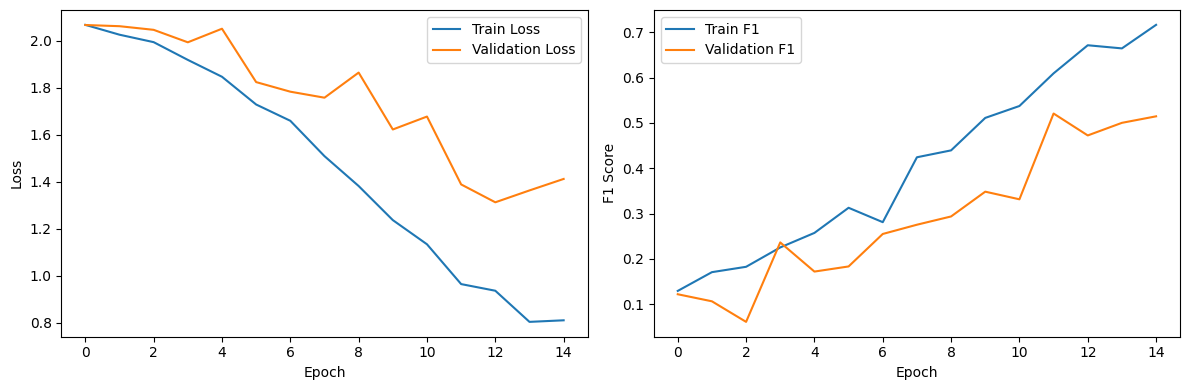

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

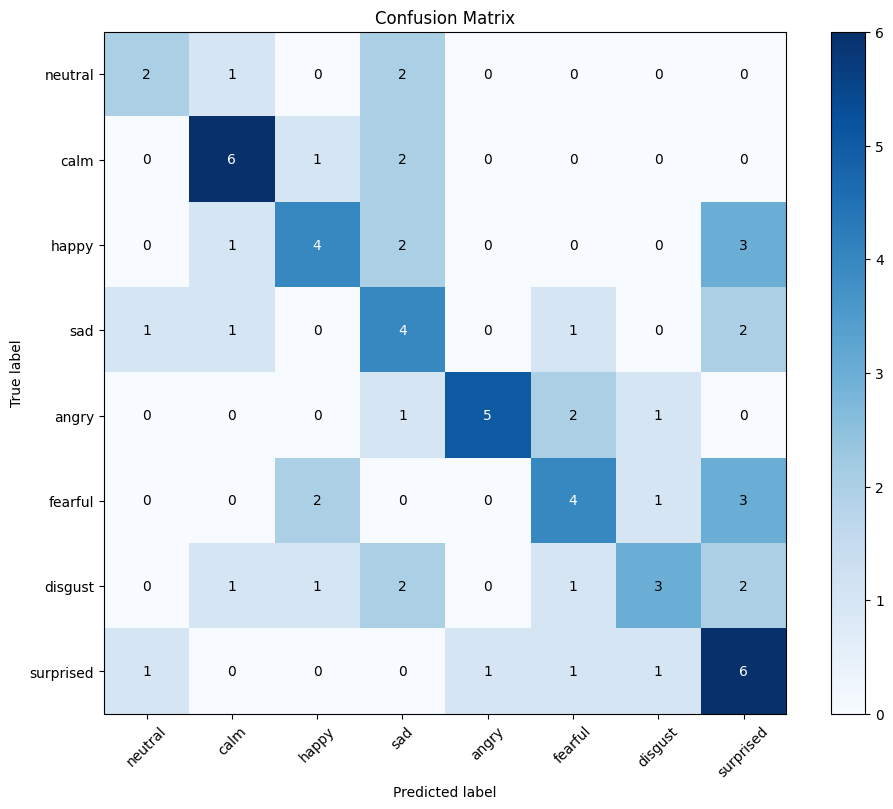

Test Accuracy: 0.4722
Test F1 Score: 0.4750


In [ ]:
# Get the dimensions from a sample batch
for audio, video, _ in train_loader:
    audio_dim = audio.shape[1]
    video_dim = video.shape[1]
    break

print(f"Audio feature dimension: {audio_dim}")
print(f"Video feature dimension: {video_dim}")

# Initialize the model
model = MultimodalEmotionClassifier(
    audio_input_dim=audio_dim,
    video_input_dim=video_dim,
    feature_dim=32,
    num_classes=8
)


print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")


model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=15,
    learning_rate=0.001
)

# Evaluate on test set
accuracy, f1, conf_matrix = evaluate_model(model, test_loader)


In [ ]:
def predict_emotion(model, audio_path, video_path):
    # Extract features
    audio_features = extract_audio_features(audio_path)
    video_features = extract_video_features(video_path)

    # Convert to tensors
    audio_tensor = torch.FloatTensor(audio_features).unsqueeze(0).to(device)
    video_tensor = torch.FloatTensor(video_features).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        outputs = model(audio_tensor, video_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted_class = torch.max(outputs, 1)

    # Map class index to emotion
    emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    predicted_emotion = emotion_labels[predicted_class.item()]

    # Get probabilities for each emotion
    probs = probabilities.cpu().numpy()[0]
    emotion_probs = {emotion: float(prob) for emotion, prob in zip(emotion_labels, probs)}

    return predicted_emotion, emotion_probs

# Test the prediction function on a sample from the test set
sample_row = test_df.iloc[40]
predicted_emotion, emotion_probs = predict_emotion(
    model,
    sample_row['audio_path'],
    sample_row['video_path']
)

print(f"True emotion: {sample_row['emotion']}")
print(f"Predicted emotion: {predicted_emotion}")
print("Emotion probabilities:")
for emotion, prob in sorted(emotion_probs.items(), key=lambda x: x[1], reverse=True):
    print(f"  {emotion}: {prob:.4f}")


True emotion: surprised
Predicted emotion: angry
Emotion probabilities:
  angry: 0.4115
  surprised: 0.2442
  fearful: 0.1552
  happy: 0.0835
  disgust: 0.0495
  sad: 0.0370
  neutral: 0.0146
  calm: 0.0045


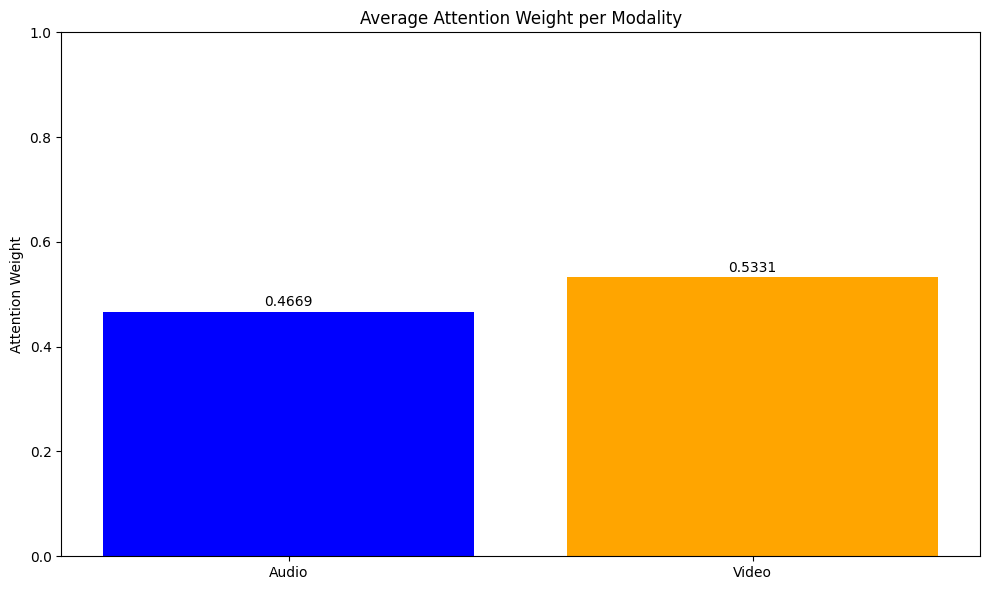

In [ ]:
def visualize_attention(model, audio_path, video_path):
    # Extract features
    audio_features = extract_audio_features(audio_path)
    video_features = extract_video_features(video_path)

    # Convert to tensors
    audio_tensor = torch.FloatTensor(audio_features).unsqueeze(0).to(device)
    video_tensor = torch.FloatTensor(video_features).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    # Get encoded features
    with torch.no_grad():
        audio_encoded = model.audio_encoder(audio_tensor)
        video_encoded = model.video_encoder(video_tensor)

        # Get attention weights
        attention_weights = F.softmax(model.fusion.attention_weights, dim=0).cpu().numpy()

    # Calculate average attention per modality
    audio_attention = attention_weights[0].mean()
    video_attention = attention_weights[1].mean()

    # Plot attention distribution
    plt.figure(figsize=(10, 6))
    plt.bar(['Audio', 'Video'], [audio_attention, video_attention], color=['blue', 'orange'])
    plt.title('Average Attention Weight per Modality')
    plt.ylabel('Attention Weight')
    plt.ylim(0, 1)

    for i, v in enumerate([audio_attention, video_attention]):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

    return audio_attention, video_attention

# Test the visualization function on a sample
sample_row = test_df.iloc[0]
audio_attention, video_attention = visualize_attention(
    model,
    sample_row['audio_path'],
    sample_row['video_path']
)


In [ ]:
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'audio_dim': audio_dim,
    'video_dim': video_dim
}, '/content/multimodal_emotion_model.pth')

#load model
def load_model(model_path):
    checkpoint = torch.load(model_path)

    model = MultimodalEmotionClassifier(
        audio_input_dim=checkpoint['audio_dim'],
        video_input_dim=checkpoint['video_dim'],
        feature_dim=32,
        num_classes=8
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    return model

# Load the model
loaded_model = load_model('/content/multimodal_emotion_model.pth')



--- Sample 254 ---
True emotion: calm


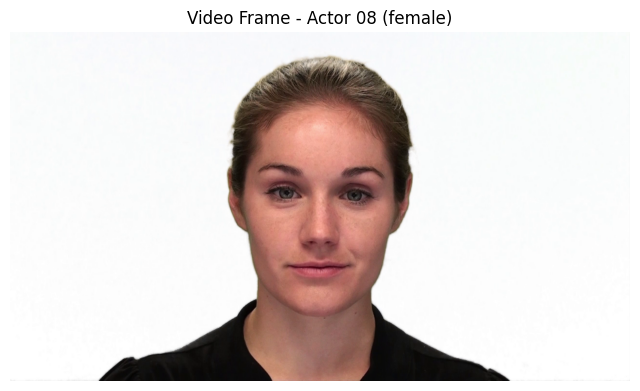

Predicted emotion: calm


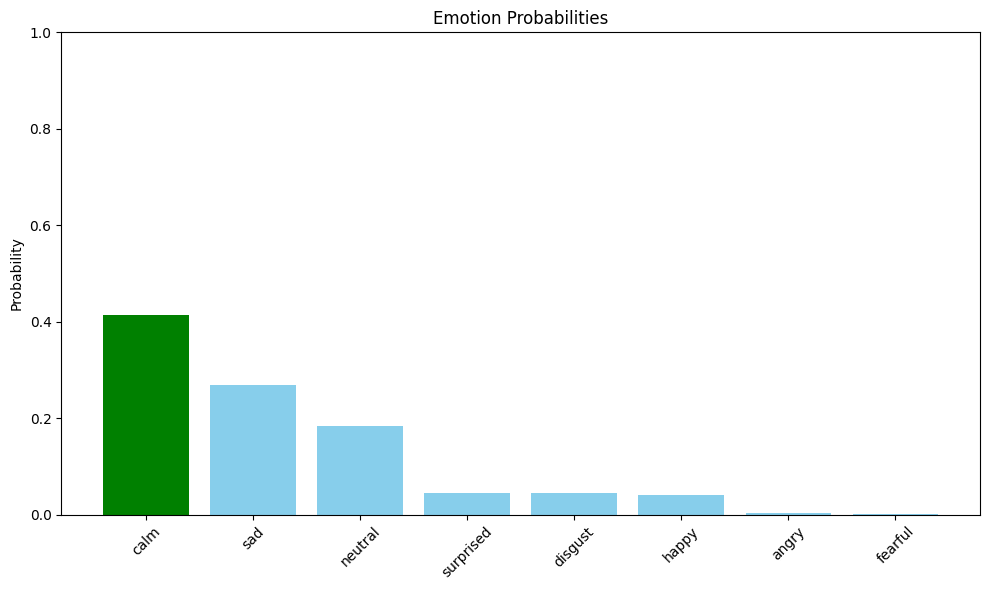

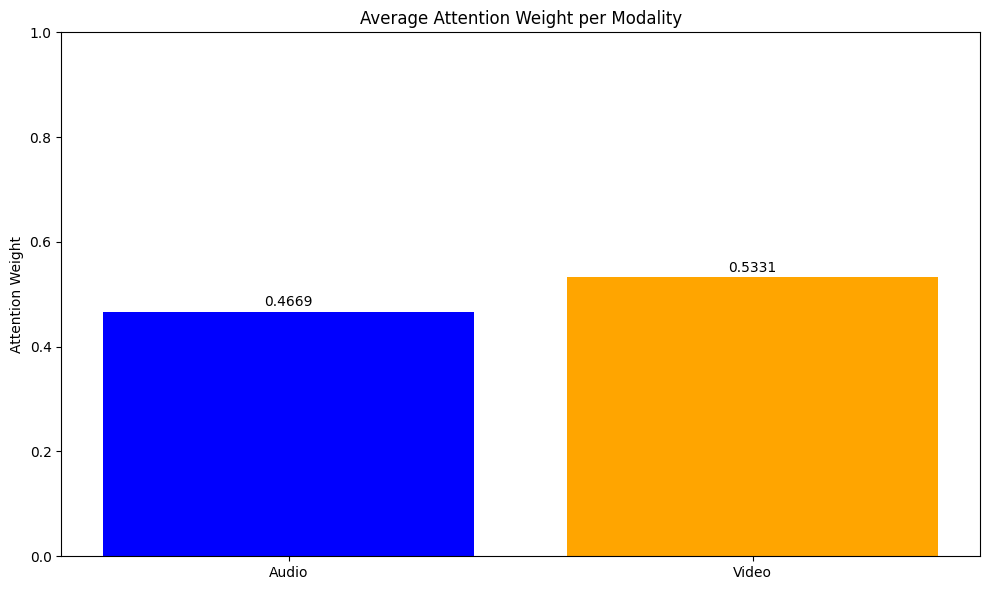


--- Sample 35 ---
True emotion: disgust


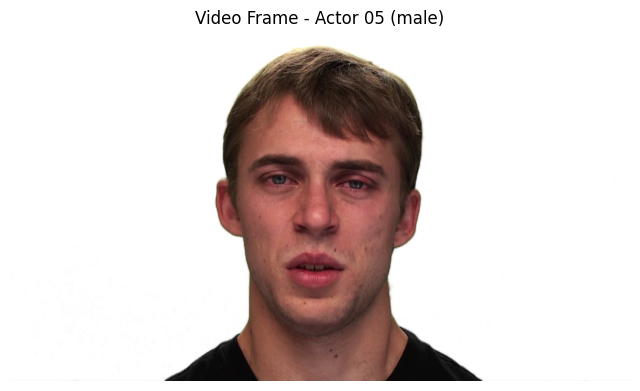

Predicted emotion: surprised


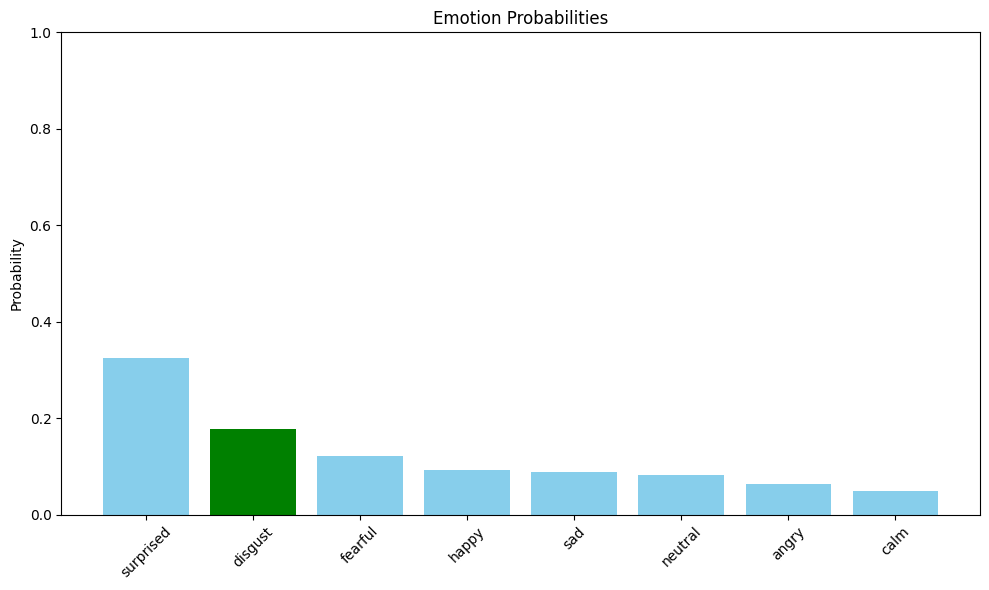

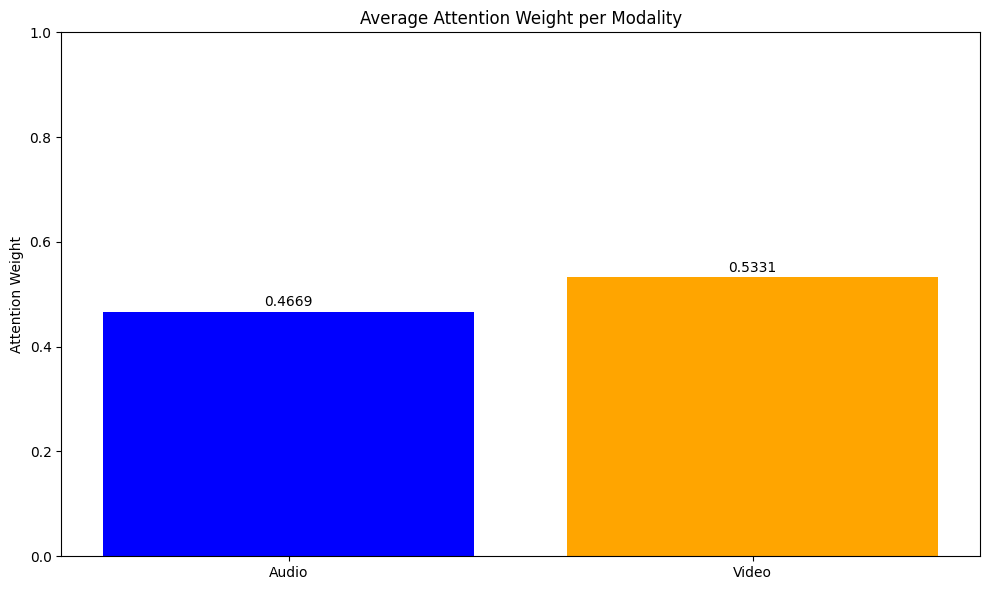


--- Sample 118 ---
True emotion: surprised


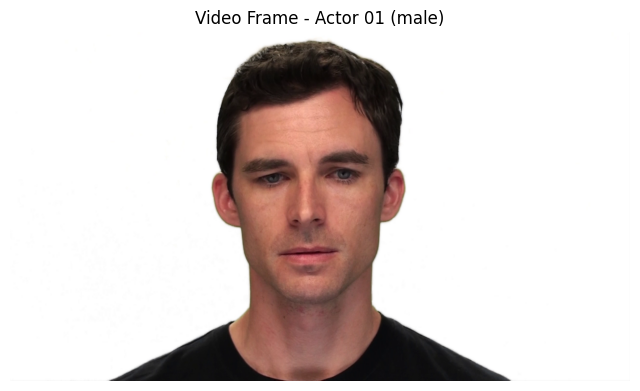

Predicted emotion: neutral


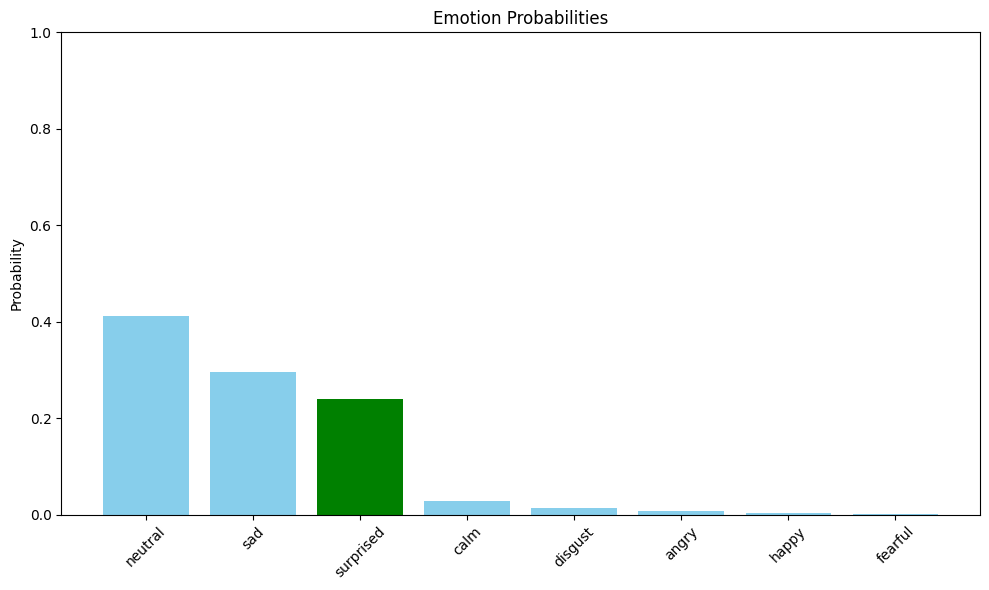

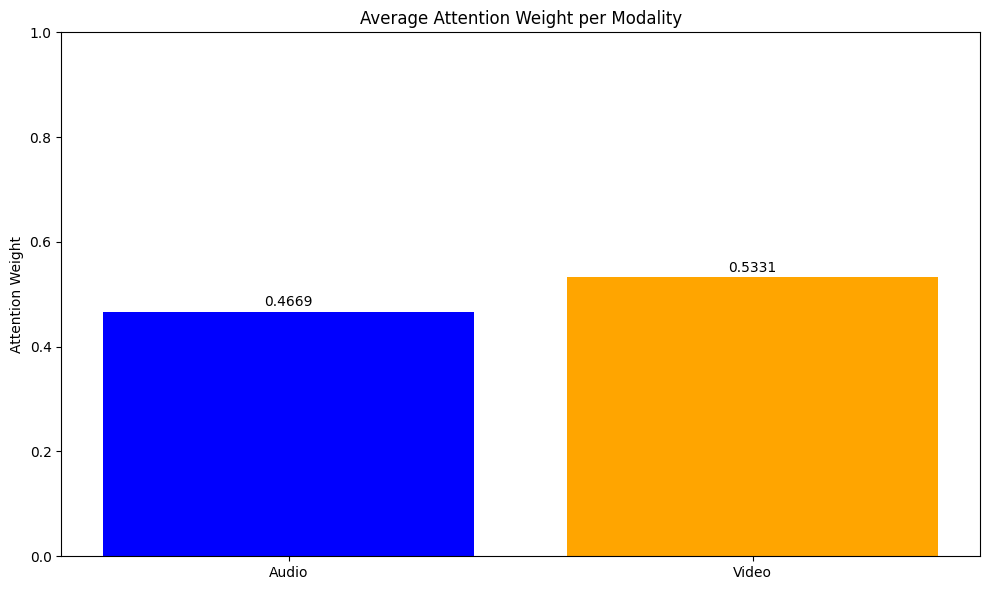


--- Sample 69 ---
True emotion: angry


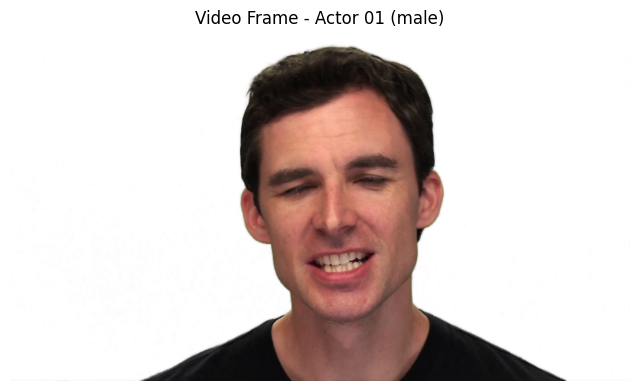

Predicted emotion: fearful


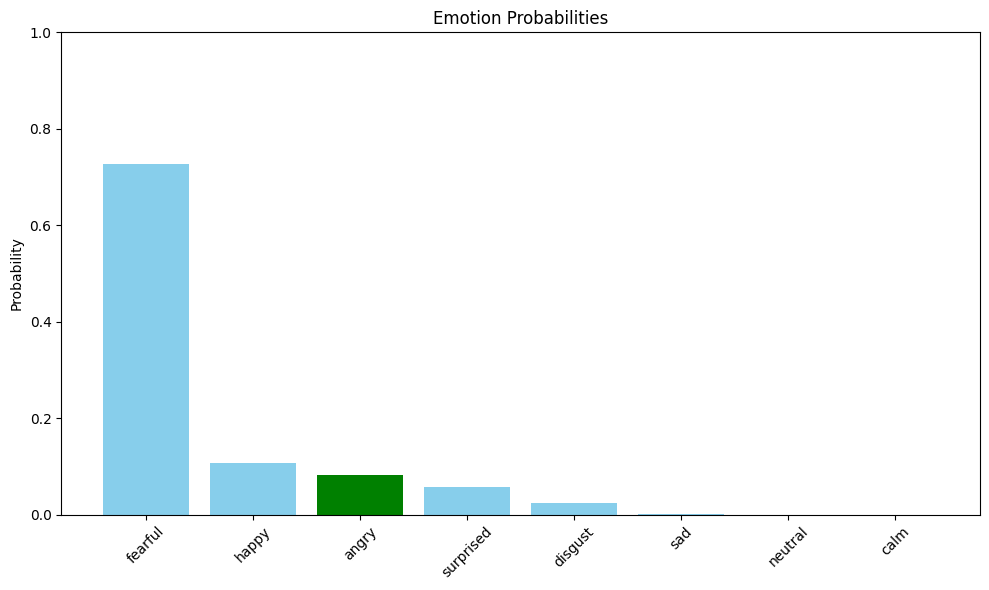

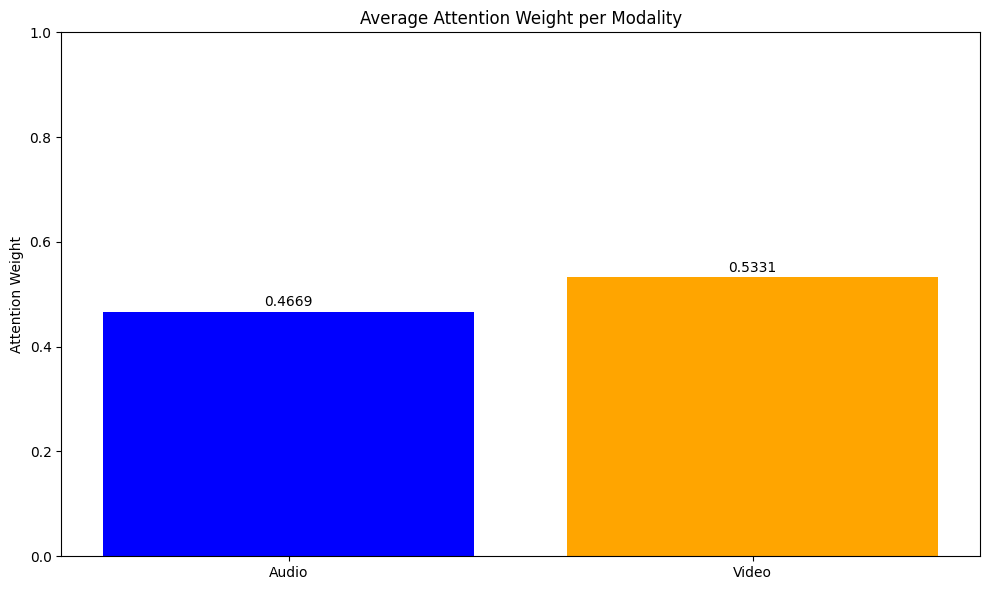


--- Sample 237 ---
True emotion: sad


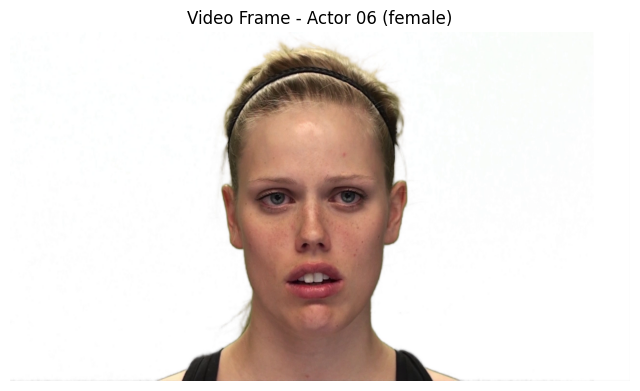

Predicted emotion: sad


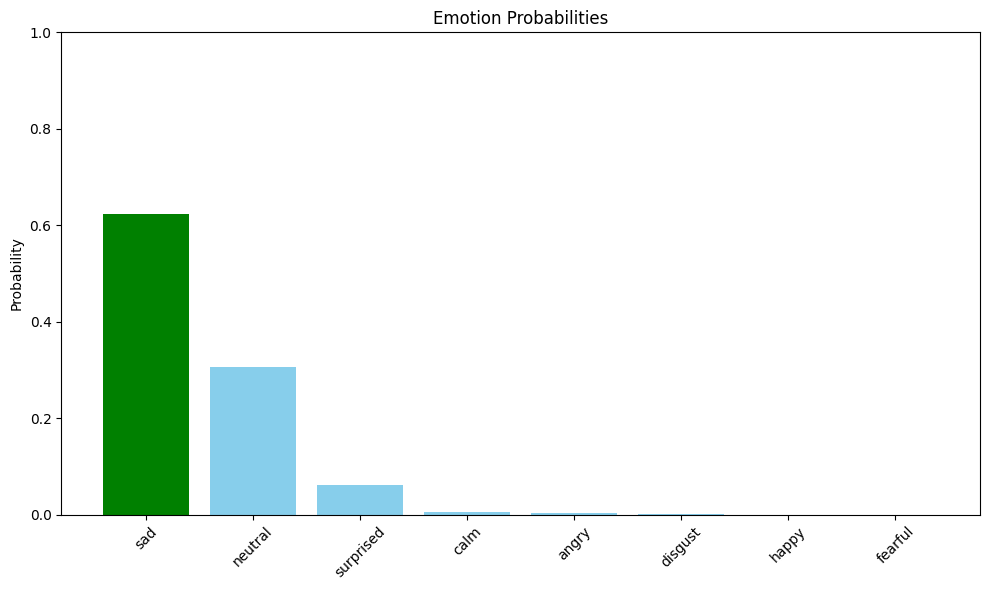

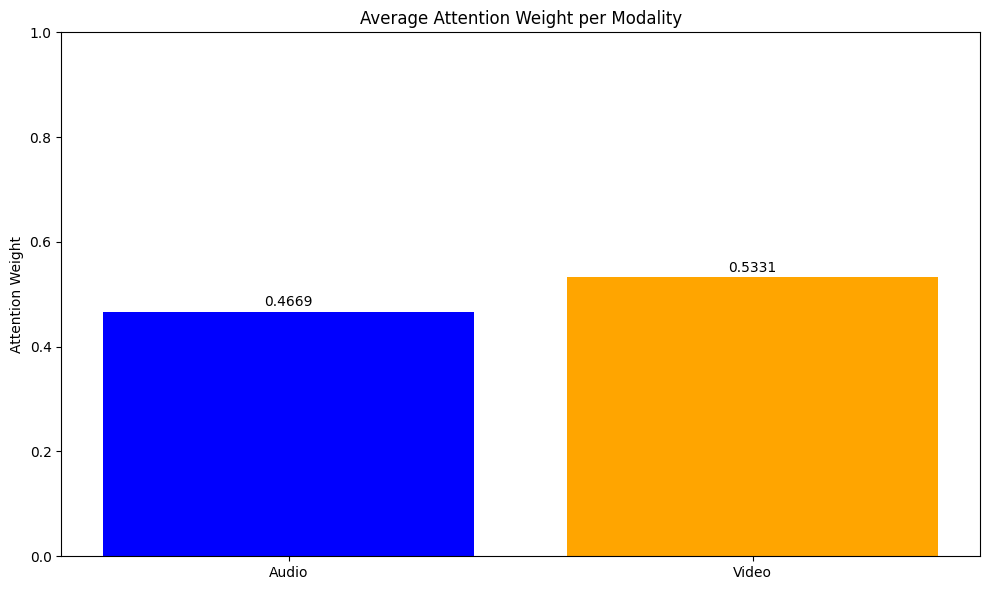

In [ ]:
from IPython.display import display, Audio, HTML
import base64

def create_demo(model):
    # Select a few test samples
    test_samples = test_df.sample(5)

    for i, row in test_samples.iterrows():
        print(f"\n--- Sample {i+1} ---")
        print(f"True emotion: {row['emotion']}")

        # Display audio
        display(Audio(row['audio_path']))

        # Display video frame
        cap = cv2.VideoCapture(row['video_path'])
        ret, frame = cap.read()
        cap.release()

        if ret:
            # Convert from BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(8, 6))
            plt.imshow(frame)
            plt.title(f"Video Frame - Actor {row['actor_id']} ({row['gender']})")
            plt.axis('off')
            plt.show()

        # Make prediction
        predicted_emotion, emotion_probs = predict_emotion(
            model,
            row['audio_path'],
            row['video_path']
        )

        print(f"Predicted emotion: {predicted_emotion}")

        # Plot emotion probabilities
        plt.figure(figsize=(10, 6))
        emotions = list(emotion_probs.keys())
        probs = list(emotion_probs.values())

        # Sort by probability
        sorted_indices = np.argsort(probs)[::-1]
        emotions = [emotions[i] for i in sorted_indices]
        probs = [probs[i] for i in sorted_indices]

        plt.bar(emotions, probs, color='skyblue')
        plt.title('Emotion Probabilities')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)

        # Highlight the true emotion
        true_idx = emotions.index(row['emotion']) if row['emotion'] in emotions else -1
        if true_idx >= 0:
            plt.bar(true_idx, probs[true_idx], color='green')

        plt.tight_layout()
        plt.show()

        # Visualize attention
        audio_attention, video_attention = visualize_attention(
            model,
            row['audio_path'],
            row['video_path']
        )

# Run demo
create_demo(model)
